# TP 03

On détient un portefeuille V contenant quatre obligations corporates émises en Euro, de nominal 100. Les obligations versent toute un coupon annuel à une même date.
- Compagnie des Alpes, coupon 3.504 euros, maturité 24/10/2027, prix de marché 113
- Korian, coupon 3.70, maturité 07/10/2025, prix de marché 110.23
- Carrefour,coupon 1, maturité 27/10/2027, prix de marché 102.22
- Total, coupon 1.023, maturité 27/10/2027, prix de marché 106.57

Les titres sont équipondérés dans le portefeuille.

L’objectif du TP est de construire un portefeuille couvert contre les variations de la courbe des taux. La table data_tp3.csv contient les courbes de taux souverains allemands et français.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')

df = pd.read_csv('data_tp3.csv', sep=';')
df.head()

,Maturity,rates,underlying,country,coupon
0,0.083333,-0.00597,AZ066741 Corp,Germany,0.0
1,0.250000,-0.00633,AZ923444 Corp,Germany,0.0
2,0.500000,-0.00617,ZR961307 Corp,Germany,0.0
3,1.000000,-0.00645,AU025425 Corp,Germany,0.0
4,2.000000,-0.00661,ZR204844 Corp,Germany,0.0


## Exercice 1

### 1.
Représentez, sur un même graphique les courbes zéro-coupons françaises et allemandes. Comment expliquez-vous les différences obtenues ?

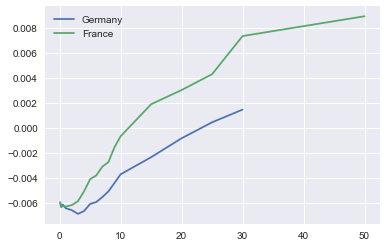

In [2]:
germany_sovereign = df[df['country']=='Germany']
french_sovereign = df[df['country']=='France']
plt.plot(germany_sovereign['Maturity'], germany_sovereign['rates'], label='Germany')
plt.plot(french_sovereign['Maturity'], french_sovereign['rates'], label='France')
plt.legend()
plt.show()

On peut voir que :

- La courbe des taux zéro coupons française est plus élevée que la courbe allemande, ce qui souligne le fait que les investisseurs ont moins confiance en la France qu'en l'Allemagne
- De manière générale, les courbes zéro coupons sont croissantes, ce qui souligne que les investisseurs ont moins confiance en l'avenir lointain que proche
- De manière locale, sur les premières années, la courbe des taux est décroissante : on parle d'inversement de la courbe des taux. Cela représente le fait que les investisseurs ont moins confiance à très court terme en l'avenir des pays évoqués. La guerre commerciale entre les Etats-Unis et la Chine ainsi que le Brexit peuvent en partie expliquer ce phénomène.

### 2.
Construire une dataframe contenant les flux de paiements reçus par échéances. Calculez le yield to maturity de chacune des positions, puis celle du portefeuille. Calculez ensuite sa duration (en fonction du yield to maturity).

In [3]:
portfolio = pd.DataFrame({
    'name':['Compagnie des Alpes', 'Korian', 'Carrefour','Total'],
    'maturity': pd.to_datetime(['24/10/2027', '07/10/2025', '27/10/2027', '27/10/2027']),
    'coupon':[3.504, 3.7, 1, 1.023],
    'price':[113, 110.23, 102.22, 106.57],
    'nominal':100
})
# On approxime : on prend uniquement l'écart entre les années
portfolio['maturity'] = [(pd.to_datetime(mat).year-pd.to_datetime('24/10/2019').year) for mat in portfolio['maturity']]
portfolio

,name,maturity,coupon,price,nominal
0,Compagnie des Alpes,8,3.504,113.00,100
1,Korian,6,3.700,110.23,100
2,Carrefour,8,1.000,102.22,100
3,Total,8,1.023,106.57,100


In [4]:
# ========== Cash flows ==========
cash_flows = pd.DataFrame({
    'maturity': range(1,9),
    'cash_flow': 0
})
for t in range(1,9):
    for i,row in portfolio.iterrows():
        cash_flows['cash_flow'][t-1] += row['coupon']
        if(t==row['maturity']):
            cash_flows['cash_flow'][t-1] += row['nominal']
cash_flows

,maturity,cash_flow
0,1,8
1,2,8
2,3,8
3,4,8
4,5,8
5,6,108
6,7,8
7,8,308


In [5]:
# ========== Yield to Maturity ==========
from scipy.optimize import newton
def yield_to_maturity(P,c,T,N):
    """
    Renvoie le yield to maturity d'une obligation. Paramètres :
        - P : le prix de l'obligation
        - c : le taux de coupon de l'obligation
        - T : la maturité de l'obligation
        - N : le nominal de l'obligation
    """
    def f(x,P,c,T,N):
        """
        Approxime la fonction de cash flows. Paramètres :
            - x : la variable permettant l'optimisation par Newton
            - P : le prix de l'obligation
            - c : le taux de coupon de l'obligation
            - T : la maturité de l'obligation
            - N : le nominal de l'obligation
        """
        result = P
        for i in range(1,int(T)):
            result -= c*N*(x**i)
        result -= N*(1+c)*(x**T)
        return result
    
    def fprime(x,P,c,T,N):
        """
        Dérivée de l'approximation de la fonction de cash flows. Paramètres :
            - x : la variable permettant l'optimisation par Newton
            - P : le prix de l'obligation
            - c : le taux de coupon de l'obligation
            - T : la maturité de l'obligation
            - N : le nominal de l'obligation
        """
        result = 0
        for i in range(1,int(T)):
            result -= i*c*N*(x**(i-1))
        result -= T*N*(1+c)*(x**(T-1))
        return result
    
    x = newton(func=f,
           x0=1.1, # puisque y est de l'ordre 0.01 et que x = 1/(1+y) 1.1 semble etre un ordre de grandeur raisonable
           fprime=fprime,
           args=(P,c,T,N)
        )
    y = 1/x - 1
    return y

In [6]:
portfolio['yield_to_maturity'] = [yield_to_maturity(row['price'],
                                                    row['coupon'] / row['nominal'],
                                                    row['maturity'],
                                                    row['nominal']) 
                                  for i,row in portfolio.iterrows()]
portfolio

,name,maturity,coupon,price,nominal,yield_to_maturity
0,Compagnie des Alpes,8,3.504,113.00,100,0.017486
1,Korian,6,3.700,110.23,100,0.018810
2,Carrefour,8,1.000,102.22,100,0.007135
3,Total,8,1.023,106.57,100,0.001945


In [7]:
portfolio['yield_to_maturity'].mean() # Le yield to maturity est un opérateur linéaire

0.011344050816573747

In [8]:
# ========== Duration ==========
def duration(c,T,N,y):
    """
    Renvoie la duration d'une obligation. Paramètres :
        - c : le taux de coupon de l'obligation
        - T : la maturité de l'obligation
        - N : le nominal de l'obligation
        - y : le yield to return de l'obligation
    """
    result = 0
    for i in range(1,int(T)):
        CF_i = c*N
        result -= (i*CF_i)/((1+y)**(i+1))
    CF_T = c*N+N
    result -= (T*CF_T)/((1+y)**(T+1))
    return result

In [9]:
portfolio['duration'] = [duration(row['coupon'] / row['nominal'],
                                    row['maturity'],
                                    row['nominal'],
                                    row['yield_to_maturity']) 
                                  for i,row in portfolio.iterrows()]
portfolio

,name,maturity,coupon,price,nominal,yield_to_maturity,duration
0,Compagnie des Alpes,8,3.504,113.00,100,0.017486,-796.884068
1,Korian,6,3.700,110.23,100,0.018810,-596.997700
2,Carrefour,8,1.000,102.22,100,0.007135,-784.749514
3,Total,8,1.023,106.57,100,0.001945,-822.482275


In [10]:
portfolio['duration'].mean() # La duration est un opérateur linéaire

-750.2783893053507

### 3.
On appelle $D_i$ l’exposition du portefeuille à un mouvement du taux zéro-coupon i. L’exposition du portefeuille à l’ensemble des taux est $D =\sum_i D_i$ avec $D_i=\frac{\partial V_i}{\partial z_i}$ et $V_i=\frac{CF_i}{(1+z_i)^i}$

Calculez D pour les taux zéro-coupons allemands puis français. Comment expliquer la différence obtenue ? Pour les deux courbes de taux
à quelle maturité la duration est-elle la plus forte ? Pourquoi ?

$V_i=\frac{CF_i}{(1+z_i)^i}=CF_i(1+z_i)^{-i}$

$D_i=\frac{\partial V_i}{\partial z_i} = -iCF_i(1+z_i)^{-(i+1)} = \frac{-iCF_i}{(1+z_i)^{i+1}}$

In [11]:
durations = pd.DataFrame({
    'maturity': range(1,9)
})
durations['french_duration'] = [(-i*cash_flows[cash_flows['maturity']==i]['cash_flow'].values[0])/
                                ((1+french_sovereign[french_sovereign['Maturity']==i]['rates'].values[0])**(i+1))
                                for i in range(1,9)]
durations['german_duration'] = [(-i*cash_flows[cash_flows['maturity']==i]['cash_flow'].values[0])/
                                ((1+germany_sovereign[germany_sovereign['Maturity']==i]['rates'].values[0])**(i+1))
                                for i in range(1,9)]

durations

,maturity,french_duration,german_duration
0,1,-8.102087,-8.104207
1,2,-16.301329,-16.321521
2,3,-24.573865,-24.674980
3,4,-32.828635,-33.090557
4,5,-41.003217,-41.498277
5,6,-665.595348,-675.690762
6,7,-57.417590,-58.554375
7,8,-2525.831055,-2580.036356


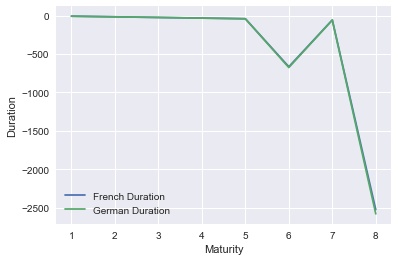

In [12]:
plt.plot(durations['maturity'], durations['french_duration'], label='French Duration')
plt.plot(durations['maturity'], durations['german_duration'], label='German Duration')
plt.xlabel('Maturity')
plt.ylabel('Duration')
plt.legend()
plt.show()

Les différences entre les durations françaises et allemandes de notre portefeuille sont très faibles, ce qui s'explique par le fait qu'il est équitablement constitués d'obligations françaises et allemandes.

Les durations sont les plus fortes aux 8emes et 6emes maturités, car ce sont les maturités lors desquelles nous recevons les nominaux des obligations.

### 4.
On souhaite désormais couvrir le risque d’un mouvement de courbe des taux. Pour cela, on va shorter des obligations souveraines (on utilise les obligations présentes dans la Table data_tp3). Nous cherchons donc à nous immuniser contre 8 risques, correspondants aux 8 maturités de la courbe des taux. Pour cela, on considère 8 obligations souveraines : O1, ..., O8 et l’on cherche les quantités φ1, ...φ8 annulant un mouvement de la courbe des taux.

On pose D, le vecteur de durations du portefeuille aux maturités 1,...,8 : 
$D = \begin{bmatrix} D1 & ... & D8\end{bmatrix}$ ; Φ, le vecteur de quantités des actifs souverains $Φ = \begin{bmatrix}φ1 & ... & φ8\end{bmatrix}$ ; et $D_0$ la matrice carrée telle que :

$D_0=\begin{bmatrix}
\frac{\partial O_1}{\partial z_1} & ... & \frac{\partial O_8}{\partial z_1} \\
... &  & ... \\
\frac{\partial O_1}{\partial z_8} & ... & \frac{\partial O_8}{\partial z_8}
\end{bmatrix}$

On rappelle qui si $D_O$ est inversible, alors : $\Phi = -DD_0^{-1}$

Dans un premier temps, on cherche se couvrir contre des mouvements de taux 1 an et de taux 8 ans. On utilise les obligations souveraines correspondants aux maturités 1 et 8.
**Dans Python, utiliser les fonctions np.dot et np.linalg.inv**.

In [13]:
# Couverture Contre les mouvements de taux allemands
# D : duration 
D=np.array([durations['german_duration'].values[0], durations['german_duration'].values[-1]])
# D_O : duration des obligations allemandes de maturités 1 et 8
germ_1 = germany_sovereign.iloc[3,:]
germ_8 = germany_sovereign.iloc[10,:]
D_O = np.array([
    [duration(germ_1['coupon'], 1, 100, germ_1['rates']), duration(germ_8['coupon'], 1, 100, germ_8['rates'])],
    [duration(germ_1['coupon'], 8, 100, germ_1['rates']), duration(germ_8['coupon'], 8, 100, germ_8['rates'])]
])
phi = np.dot(-D, np.linalg.inv(D_O))
phi

array([14.9340803 , -1.79364645])

In [14]:
D

array([   -8.10420712, -2580.0363556 ])

In [15]:
D_O

array([[ -101.30258896,  -151.5417846 ],
       [ -847.97380742, -2700.18294217]])

In [16]:
# Couverture Contre les mouvements de taux français
# D : duration 
D=np.array([durations['french_duration'].values[0], durations['french_duration'].values[-1]])
# D_O : duration des obligations fr de maturités 1 et 8
french_1 = french_sovereign.iloc[3,:]
french_8 = french_sovereign.iloc[10,:]
D_O = np.array([
    [duration(french_1['coupon'], 1, 100, french_1['rates']), duration(french_8['coupon'], 1, 100, french_8['rates'])],
    [duration(french_1['coupon'], 8, 100, french_1['rates']), duration(french_8['coupon'], 8, 100, french_8['rates'])]
])
phi = np.dot(-D, np.linalg.inv(D_O))
phi

array([30.39699854, -3.64527682])

### 5.
Calculez désormais les quantités d’actifs nécessaires pour se couvrir contre une variation de l’ensemble de la courbe des taux.

## Exercice 2
On souhaite désormais se couvrir en supposant que la courbe des taux est générée par le modèle de Vasicek. Dans ce cadre, la diffusion du taux court r<sub>t</sub> est donnée par :

$dr_t = a(b-r_t)dt + \sigma d W_t$ avec a > 0 la vitesse de retour à la moyenne, b la moyenne de long terme, σ > 0 l’écart-type et Wt un mouvement brownien.

Tout d’abord on souhaite approximer l’équation continue afin d’effectuer des simulations. On divise l’intervalle [0, T] en k intervalles de longueurs h tel que T = hk. Dans le cas où un intervalle dure un mois, alors h = 1 12 et k = 36 si T = 3.

Une version discrète est donnée par : $r_{t+1} = r_t + a(b-r_t)h + \sigma \sqrt{h} z_{t+1}$ avec $z_t$ ~ $N(0,1)$

### 1.
Simulez des processus pour r0 = 0.01, a = 0.02, σ = 0.02, b = 0.005, h = 112 et k = 36. Puis pour a = 0.1. Qu’observez-vous ?

In [17]:
import math
def discrete_vasicek(r_t, a, b, h, sigma):
    """
    Returns the r_t_plus_1 based on the discrete version of Vasicek model.
    Parameters:
        - r_t: the rate in the current time period.
        - a:tThe speed of come back to b
        - b: the long term mean
        - h: length of the time intervals (in year)
        - sigma:
    """
    z_t_plus_1 = np.random.normal()
    return r_t + a * (b - r_t) * h + sigma * math.sqrt(h) * z_t_plus_1

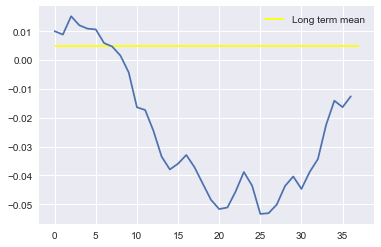

In [18]:
r = np.array([.01])
a = .02
sigma = .02
b = .005
h = 1/12
k = 36

for t in range(1, k+1):
    r = np.append(r, discrete_vasicek(r[-1], a, b, h, sigma))
    
plt.plot(range(k+1), r)
plt.hlines(y=b, xmin=0, xmax=k+1, colors='yellow', label='Long term mean')
plt.legend()
plt.show()

On peut observer que, selon le modèle de Vasicek, notre taux fluctue autour de la moyenne de long terme, en l'occurence b = 0.005.

### 2.
On appelle z(T) le taux zéro-coupon de maturité T tel que : $z(T)=z_\infty + s \frac{\Phi(T)}{T} + \frac{\sigma^2}{4a^3} \frac{\Phi(T)^2}{T}$ avec :

- $z_\infty = b- \frac{\sigma^2}{2a^2}$
- $s = r_0 - z_\infty$ où $r_0$ est le taux court vu en 0
- $\Phi(T) = \frac{1-e^{-aT}}{a}$

Pour le reste du TP, on considèrera le facteur d’actualisation à la maturité i sous sa forme continue i.e. $\frac{1}{(1+z_i)}$ devient $e^{-iz(i,z_\infty, s, \sigma^2)}$, et $z_i$ devient $z(i, z_\infty, s, \sigma^2)$

### 3.
Définir une fonction permettant de simuler une courbe de taux à partir de l’équation ci-dessus. Simuler une courbe de taux avec les paramètres suivants :
- b=0
- r0=-0.005
- a=0.01
- sigma=0.001
- T=10
- une fréquence d’un an

Qu’observez-vous ?

In [19]:
def vasicek_new(T, b, r_0, a, sigma):
    """
    Retourne la valeur en T de la courbe de taux simulée par la nouvelle équation fournie après Vasicek.
    """
    z_infty = b - (sigma**2)/(2*a**2)
    s = r_0 - z_infty
    phi_T = (1-math.exp(-a*T))/a
    z_T = z_infty + s*phi_T/T + sigma**2 / (4*a**3) * phi_T**2 / T
    return z_T

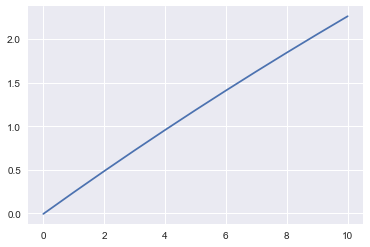

In [20]:
b = 0
r_0 = -0.005
a = .01
sigma = .001
T = 10

r = np.array(r_0)
for T in range(1,11):
    r = np.append(r, vasicek_new(T, b, r_0, a, sigma))

plt.plot(range(11), r)
plt.show()

### 4.
On isole désormais les trois facteurs générant des mouvements de courbe des taux : z∞ (shift), s (pente), σ2 (torsion). Calculez et écrivez une fonction renvoyant : $\frac{\partial V_i}{\partial z_\infty}$, 
$\frac{\partial V_i}{\partial s}$,
$\frac{\partial V_i}{\partial \sigma^2}$. 
On supposera que $V_i = CF_i e^{-iz(i, z_\infty, s, \sigma^2)}$

$\frac{\partial V_i}{\partial z_\infty} = \frac{\partial(CFi e^{-iz(i, z_\infty, s, \sigma^2)})}{\partial z_\infty}$

$= CF_i *(-i)* \frac{\partial z(i, z_\infty, s, \sigma^2)}{\partial z_\infty} e^{-iz(i, z_\infty, s, \sigma^2)}$ avec $-i \frac{\partial z(i, z_\infty, s, \sigma^2)}{\partial z_\infty} = i(\frac{\Phi(T)}{T}-1)$

$\frac{\partial V_i}{\partial z_\infty} =  CF_i i(\frac{\Phi(T)}{T}-1) e^{-iz(i, z_\infty, s, \sigma^2)}$

In [21]:
#TODO: i=T, simplifier

In [22]:
def derivative_z_infty(CF_T, T, b, r_0, a, sigma):
    """
    Returns the derivative of V_T relative to z_infty.
    """
    phi_T = (1-math.exp(-a*T))/a
    return CF_T * T *(phi_T / T -1) * math.exp(-T * vasicek_new(T, b, r_0, a, sigma))

$\frac{\partial V_i}{\partial s} = \frac{\partial(CFi e^{-iz(i, z_\infty, s, \sigma^2)})}{\partial s}$

$= CF_i *(-i)* \frac{\partial z(i, z_s, s, \sigma^2)}{\partial z_s} e^{-iz(i, z_\infty, s, \sigma^2)}$ avec $\frac{\partial z(i, z_s, s, \sigma^2)}{\partial z_s} = \frac{\Phi(T)}{T}$

$\frac{\partial V_i}{\partial s} = CF_i (-i) \frac{\Phi(T)}{T} e^{-i z(i, z_\infty, s, \sigma^2)}$

In [23]:
#TODO: i=T, simplifier

In [24]:
def derivative_s(CF_T, T, b, r_0, a, sigma):
    """
    Returns the derivative of V_T relative to s.
    """
    phi_T = (1-math.exp(-a*T))/a
    return CF_T * -T * phi_T / T * math.exp(-T * vasicek_new(T, b, r_0, a, sigma))

$\frac{\partial V_i}{\partial \sigma^2} = \frac{\partial(CFi e^{-iz(i, z_\infty, s, \sigma^2)})}{\partial \sigma^2}$

$= CF_i (-i) \frac{\partial z}{\partial \sigma^2} e^{-iz(i, z_\infty, s, \sigma^2)}$ avec $\frac{\partial z}{\partial \sigma^2} = \frac{\partial z_\infty}{\partial \sigma^2} + \frac{1}{4a^3}$ et $\frac{\partial z_\infty}{\partial \sigma^2} = \frac{-1}{2a^2}$

$\frac{\partial V_i}{\partial \sigma^2} = CF_i (-i) (\frac{-1}{2a^2} + \frac{1}{4a^3}) e^{-iz(i, z_\infty, s, \sigma^2)}$

In [25]:
def derivative_sigma_2(CF_T, T, b, r_0, a, sigma):
    """
    Returns the derivative of V_T relative to s.
    """
    return CF_T * -T * (-1/(2*a**2) + 1/(4*a**3)) * math.exp(-T * vasicek_new(T, b, r_0, a, sigma))